IMPORT & DEVICE

In [ ]:
import nibabel as nib
import numpy as np
import scipy.ndimage
import torch
import torch.nn as nn
import torch.nn.functional as F
import os,zipfile,requests
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.tensorboard import SummaryWriter
import glob
import random

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
device= get_device()

In [ ]:
#normal CT scans
normal_url="https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"

#abnormal CT scans
abnormal_url="https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"


def download_and_extract(url, dest_dir):
    zip_path = os.path.join(dest_dir, os.path.basename(url))
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    if not os.path.exists(zip_path):
        print(f"Downloading {url}...")
        r = requests.get(url)
        with open(zip_path, 'wb') as f:
            f.write(r.content)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dest_dir)

download_and_extract(normal_url, "./data/normal")
download_and_extract(abnormal_url, "./data/abnormal")

In [ ]:
desired_height = 128
desired_width = 128
desired_depth = 64
#这些是否是可以自定义的？

In [ ]:
epochs=10
#epochs多少最佳？

lr=0.001
#lr添加在哪里？多少最佳？

criterion=nn.BCEWithLogitsLoss()

num_slices=10

PREPROCESS

read nifti file

input: filepath

output:(array)

util: nib.load
      get_fdata

In [ ]:
def read_nifti_file(filepath):
    imgs=nib.load(filepath)
    volume=imgs.get_fdata()
    return volume

normalize_volume

input:volume

output:volume

util:np.clip

HU window [-1000,400]------>[0,1]

In [ ]:
def normalize_volume(volume):
    HU_up_bound=400
    HU_low_bound=-1000

    volume=np.clip(volume, HU_low_bound, HU_up_bound)
    volume = (volume - HU_low_bound) / (HU_up_bound - HU_low_bound)
    volume=volume.astype(np.float32)

    return volume


resize_volume

input:img, desired_depth, desired_width, desired_height

output:img

util:scipy.ndimage.zoom

In [ ]:
def resize_volume(volume, desired_depth, desired_height, desired_width):
    volume = scipy.ndimage.zoom(volume, (desired_depth/volume.shape[0], desired_height/volume.shape[1], desired_width/volume.shape[2]), order=1)
    return volume

process_scan

input:path

output:(array) volume 

In [ ]:
def process_data(filepath):
    volume = read_nifti_file(filepath)
    volume = normalize_volume(volume)
    volume = resize_volume(volume, desired_depth, desired_height, desired_width)
    return volume

DATASET & DATALAOD

CTDataset

input: data_dir, label_dir

output: (tensor)volume, (tensor)label

In [ ]:
class CTDataset(Dataset):
    def __init__(self, data_path, labels):
        self.data_path = data_path
        self.labels = labels

    def __len__(self):
        return len(self.data_path)
    
    def __getitem__(self, idx):
        volume=process_data(self.data_path[idx])
        volume=torch.tensor(volume).unsqueeze(0).float()
        label=torch.tensor(self.labels[idx]).float()
        return volume,label


load_split_datasets

input: data_dir, label_dir, train_split

output: train_dataset (volume,label), val_dataset (volume,label)

In [ ]:
def load_split_dataset(normal_dir, abnormal_dir, train_split=0.7):
    normal_files=glob.glob(os.path.join(normal_dir, "*.nii*" ))
    normal_labels=[0]*len(normal_files)

    abnormal_files=glob.glob(os.path.join(abnormal_dir, "*.nii*" ))
    abnormal_labels=[1]*len(abnormal_files)
    
    all_files=normal_files+abnormal_files
    all_labels=normal_labels+abnormal_labels

    combines=list(zip(all_files,all_labels))
    random.shuffle(combines)
    
    all_files, all_labels=zip(*combines)

    split_idx=int(len(all_files)*train_split)
    train_files=list(all_files[:split_idx])
    train_labels=list(all_labels[:split_idx])
    val_files=list(all_files[split_idx:])
    val_labels=list(all_labels[split_idx:])
    
    train_dataset=CTDataset(train_files, train_labels)
    val_dataset=CTDataset(val_files, val_labels)
    return train_dataset, val_dataset

normal_dir="./data/normal"
abnormal_dir="./data/abnormal"

train_dataset, val_dataset=load_split_dataset(normal_dir, abnormal_dir, train_split)

MODEL

3DCNN

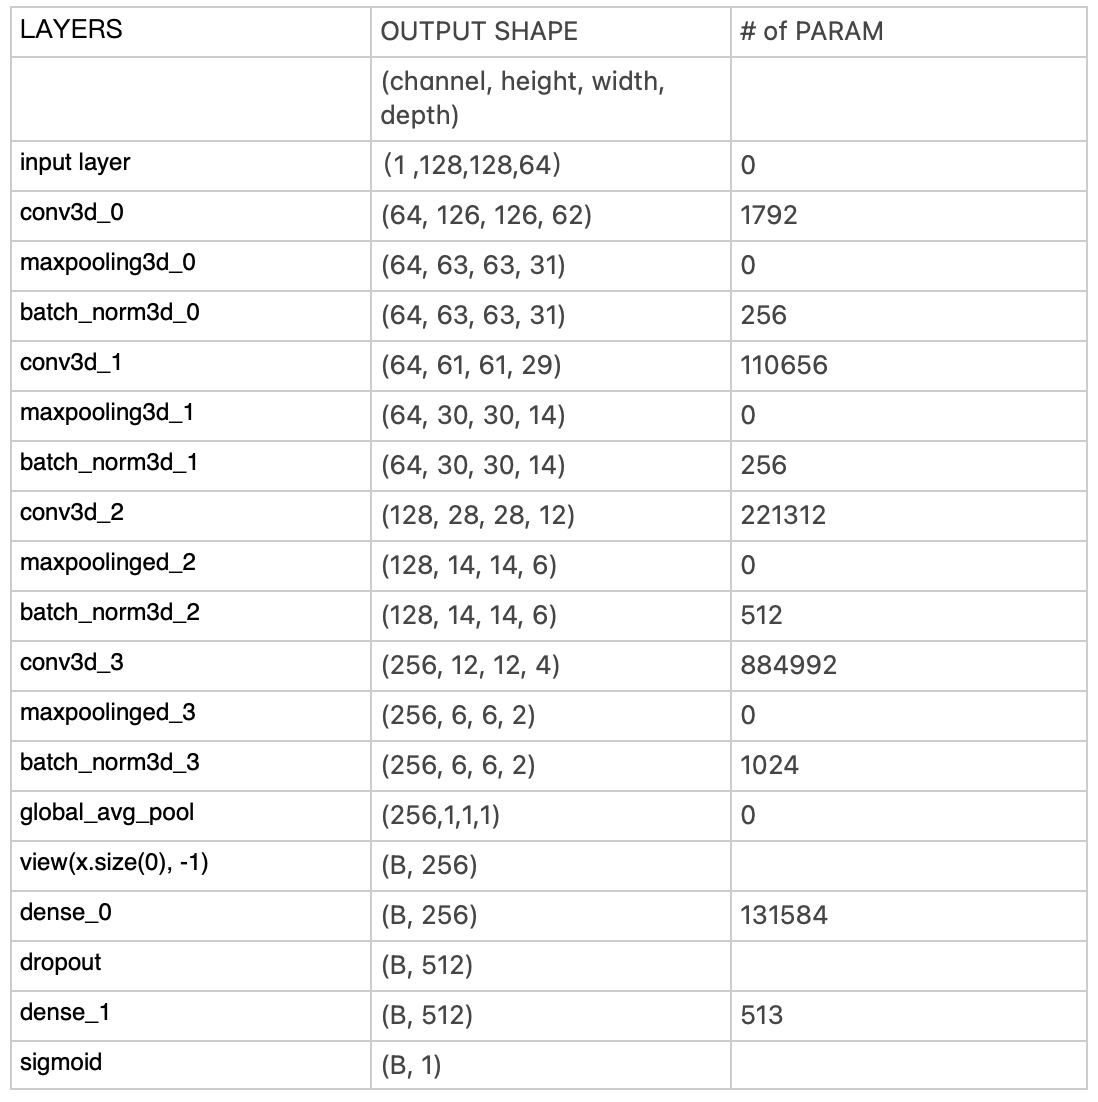




问题一：stride和padding的大小？

问题二：dense layer就是fully connect layer吗？

问题三：什么位置放relu？

In [ ]:
class Simple3DCNN(nn.Module):
    def __init__(self):
        super(Simple3DCNN, self).__init__()
        self.block_0=nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )
        self.block_1=nn.Sequential(
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )
        self.block_2=nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )
        self.block_3=nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )
        self.global_avg_pool=nn.AdaptiveAvgPool3d((1, 1, 1))
        self.dense_0=nn.Linear(256, 512)
        self.relu=nn.ReLU()
        self.dropout=nn.Dropout(0.5)
        self.dense_1=nn.Linear(512, 1)

    def forward(self, x):
        x=self.block_0(x)
        x=self.block_1(x)
        x=self.block_2(x)
        x=self.block_3(x)
        x=self.global_avg_pool(x)
        x=x.view(x.size(0), -1)
        x=self.dense_0(x)
        x=self.dropout(x)
        x=self.relu(x)
        x=self.dense_1(x)
        return x

TRAIN

train
input:model,train_dataset,val_dataset
output:model

In [ ]:
def visualize_input_output(volume,num_slices=num_slices):
    depth=volume.shape[2]
    step=max(1, depth // num_slices)
    fig, axes = plt.subplots(1, num_slices, figsize=(20, 5))
    for i ,ax in enumerate(axes):
        slice_idx=i*step
        ax.imshow(volume[slice_idx],cmap='gray')
        ax.axis('off')
        ax.set_title(f'Slice {slice_idx}')
    plt.show()

In [ ]:
def plot_confusion_matrix(val_preds, val_labels, epoch):
    cm = confusion_matrix(val_labels, val_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix at Epoch {epoch}')
    plt.show()

In [ ]:
train_dataloader = DataLoader(train_dataset,batch_size=4,shuffle=True, num_workers=1)
val_dataloader = DataLoader(val_dataset,batch_size=4,shuffle=False, num_workers=1)

model=Simple3DCNN().to(device)

optimizer=torch.optim.Adam(model.parameters(), lr=lr)

writer= SummaryWriter(log_dir='./runs/Chang_3D_CT_Pytorch_impl')

def train(model, train_dataloader, val_dataloader):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        running_total = 0

        for volume, labels in train_dataloader:
            volume=volume.to(device)
            labels=labels.to(device)

            optimizer.zero_grad()
            outputs=model(volume)
            loss=criterion(outputs, labels.float().unsqueeze(1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * volume.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            running_corrects += (preds == labels).sum().item()
            running_total += labels.size(0)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects / running_total



        model.eval()
        val_loss= 0.0
        val_corrects = 0
        val_total = 0

        val_preds=[]
        val_labels=[]

        with torch.no_grad():
            for volume, labels in val_dataloader:
                volume=volume.to(device)
                labels=labels.to(device)

                outputs=model(volume)
                loss=criterion(outputs, labels.float().unsqueeze(1))

                val_loss += loss.item() * volume.size(0)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_corrects += (preds == labels).sum().item()
                val_total += labels.size(0)

                preds.to(device)
                labels.to(device)
                val_preds.append(preds)
                val_preds = torch.cat(val_preds)
                val_labels.append(labels)
                val_labels = torch.cat(val_labels)

        
        val_epoch_loss = val_loss / len(train_dataset)
        val_epoch_acc = val_corrects / val_total


        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")
        
        writer.add_scalar('Loss/train', epoch_loss, epoch)
        writer.add_scalar('Accuracy/train', epoch_acc, epoch)
        writer.add_scalar('Loss/val', val_epoch_loss, epoch)
        writer.add_scalar('Accuracy/val', val_epoch_acc, epoch)

        plot_confusion_matrix(val_preds, val_labels, epoch) 
        
    writer.close()
    return model

PREDICT

In [ ]:
def predict_signal_ct(model,ct_path,device):
    model.eval()
    with torch.no_grad():
        volume=process_data(ct_path)
        output=model(volume)
        prob=torch.sigmoid(output)
        result=1 if prob>0.5 else 0
        return prob,result
    

In [ ]:
def main():
    